# LimberJack Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
using LinearAlgebra
using Turing
using LimberJack
using DataFrames
using CSV
using YAML
using NPZ
using PythonCall
sacc = pyimport("sacc");

using Revise
using MicroCanonicalHMC

    CondaPkg Found dependencies: /home/jaimerz/.julia/environments/v1.9/CondaPkg.toml
    CondaPkg Found dependencies: /home/jaimerz/.julia/packages/PythonCall/3GRYN/CondaPkg.toml
    CondaPkg Dependencies already up to date


In [3]:
sacc_path = "/home/jaimerz/PhD/LimberJack.jl/data/FD/cls_FD_covG.fits"
yaml_path = "/home/jaimerz/PhD/LimberJack.jl/data/DECALS/DECALS.yml"
sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)
meta, files = make_data(sacc_file, yaml_file)

data = meta.data
cov = meta.cov

DECALS__0 DECALS__0 3
DECALS__1 DECALS__1 7
DECALS__2 DECALS__2 9
DECALS__3 DECALS__3 11


In [4]:
@model function model(data)
    #KiDS priors
    Ωm ~ Uniform(0.2, 0.6)
    Ωb ~ Uniform(0.028, 0.065)
    h ~ TruncatedNormal(72, 5, 0.64, 0.82)
    s8 ~ Uniform(0.4, 1.2)
    ns ~ Uniform(0.84, 1.1)

    DECALS__0_b ~ Uniform(0.8, 3.0)
    DECALS__1_b ~ Uniform(0.8, 3.0)
    DECALS__2_b ~ Uniform(0.8, 3.0)
    DECALS__3_b ~ Uniform(0.8, 3.0)
    DECALS__0_dz ~ TruncatedNormal(0.0, 0.007, -0.2, 0.2)
    DECALS__1_dz ~ TruncatedNormal(0.0, 0.007, -0.2, 0.2)
    DECALS__2_dz ~ TruncatedNormal(0.0, 0.006, -0.2, 0.2)
    DECALS__3_dz ~ TruncatedNormal(0.0, 0.01, -0.2, 0.2)

    nuisances = Dict("DECALS__0_b" => DECALS__0_b,
                     "DECALS__1_b" => DECALS__1_b,
                     "DECALS__2_b" => DECALS__2_b,
                     "DECALS__3_b" => DECALS__3_b,
                     "DECALS__0_dz" => DECALS__0_dz,
                     "DECALS__1_dz" => DECALS__1_dz,
                     "DECALS__2_dz" => DECALS__2_dz,
                     "DECALS__3_dz" => DECALS__3_dz)

    cosmology = Cosmology(Ωm, Ωb, h, ns, s8,
                          tk_mode="EisHu",
                          Pk_mode="Halofit")

    theory = Theory(cosmology, meta, files; Nuisances=nuisances)
    data ~ MvNormal(theory, cov)
end

model (generic function with 2 methods)

In [5]:
stat_model = model(data);

## Sampling

In [30]:
target = TuringTarget(stat_model; compute_MAP=false);
spl = MCHMC(0.01, 0.13; varE_wanted=1.0, sigma=ones(13))

MicroCanonicalHMC.Sampler(MicroCanonicalHMC.Settings(Random.MersenneTwister(0), 1.0, 0, 1000, 100, "LF", nothing, nothing, nothing), Hyperparameters(0.01, 0.13, 0.0, 0.1931833275037836, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), MicroCanonicalHMC.Leapfrog)

In [31]:
samples = Sample(spl, target, 1000; dialog=true)

[ Info: Using given sigma ✅
[ Info: Using given eps ✅
[ Info: Using given L ✅


1001-element Vector{Any}:
 [0.5403005606698671, 0.02810587732752035, 0.7704652727769314, 0.9841764684945528, 0.8776395549782469, 1.0050442600864624, 1.3754270520137117, 1.5257338485694292, 1.6891078460906916, -0.0034238303644062718, 0.0010025093992553913, 0.010080470916689788, -0.00999930409441177, 0.0, -13548.317737786367]
 [0.5402782061494189, 0.02810587741067113, 0.770462261811389, 0.9831309604893689, 0.8776442650440348, 1.0050286006384743, 1.374750572123872, 1.5225791124415426, 1.6878808021581957, -0.003437183557318535, 0.0009228046089674868, 0.009860346734239245, -0.01005362076161151, 20.62165593258578, -13218.602479818275]
 [0.5402561119735227, 0.02810587749375973, 0.7704598509695899, 0.9820786924835571, 0.8776489751219505, 1.005012911513086, 1.3740714650392487, 1.5194385585221066, 1.686652443931929, -0.0034505397101197988, 0.0008428924349905831, 0.009643394412744755, -0.010107572630882466, 47.00248916972305, -12894.335321982866]
 [0.5402332118871507, 0.028105877577320137, 0.7704

In [32]:
Wms = [sample[1] for sample in samples]
std(Wms)

0.08844307341653813

In [35]:
b1s = [sample[6] for sample in samples]
std(b1s)

0.047831389260418626

In [33]:
using Plots

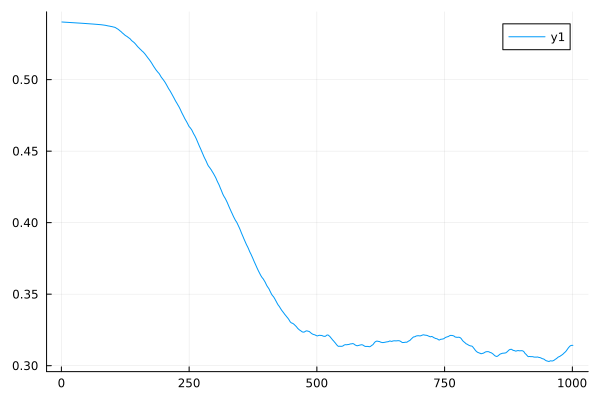

In [34]:
plot(Wms)

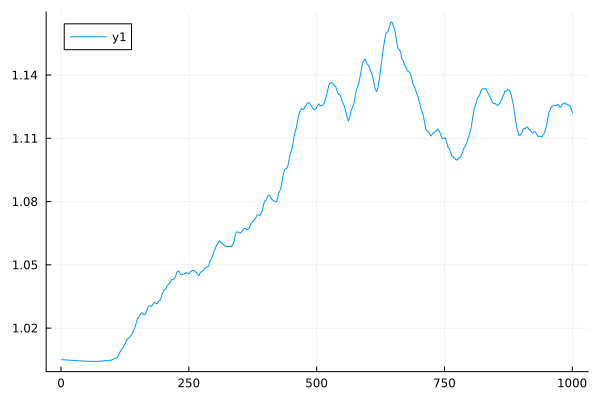

In [36]:
plot(b1s)

## NUTS

In [39]:
samples_hmc = sample(stat_model, NUTS(100, 0.65),
                     300, progress=true; save_state=true)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Info: Found initial step size
└   ϵ = 0.0125
Sampling:   4%|█▍                                       |  ETA: 0:02:26┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
Sampling: 100%|█████████████████████████████████████████| Time: 1:14:57


Chains MCMC chain (300×25×1 Array{Float64, 3}):

Iterations        = 101:1:400
Number of chains  = 1
Samples per chain = 300
Wall duration     = 4502.67 seconds
Compute duration  = 4502.67 seconds
parameters        = Ωm, Ωb, h, s8, ns, DECALS__0_b, DECALS__1_b, DECALS__2_b, DECALS__3_b, DECALS__0_dz, DECALS__1_dz, DECALS__2_dz, DECALS__3_dz
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
    parameters      mean       std   naive_se      mcse        ess      rhat   ⋯
        Symbol   Float64   Float64    Float64   Float64    Float64   Float64   ⋯

            Ωm    0.2811    0.0226     0.0013    0.0024    98.0312    1.0213   ⋯
            Ωb    0.0402    0.0069     0.0004    0.0005   144.1265    1.0020   ⋯
             h    0.7376    0.0470     0.0027    0.0050   105.2713    1.0019   ⋯
            s8    0.9177   

In [15]:
summary_hmc.ess

25-element Vector{Float64}:
  107.13649180104869
  331.4835789816811
  207.484061400768
  111.64048654758332
  600.4013034569028
  114.39496059843647
  117.33719647252566
  114.56966849849671
  111.15547545924896
  105.06968640469209
  961.3377488207435
  700.0507524844818
  837.2166448905194
  682.3676139298411
  566.0490257440192
  837.5008331222044
  733.9973963424983
  549.1048795030388
  792.5424251430129
 1009.6818545217956
  763.2299996132994
  872.0250289709837
  763.7811879280131
  552.5319549420313
  731.942598764305

In [16]:
Wms_hmc = vec(samples_hmc[!, "Ωm"])
s8s_hmc = vec(samples_hmc[!, "s8"]);

In [17]:
Wm_hmc_ker = ash(Wms_hmc; m=30)
s8_hmc_ker = ash(s8s_hmc; m=30)
Wm_mchmc_ker = ash(Wms_mchmc; m=30)
s8_mchmc_ker = ash(s8s_mchmc; m=30);

LoadError: UndefVarError: `Wms_mchmc` not defined

In [18]:
Plots.plot(Wm_mchmc_ker; hist=false, label="MCHMC")
Plots.plot!(Wm_hmc_ker; hist=false, label="HMC", xlabel="Wm")

LoadError: UndefVarError: `Wm_mchmc_ker` not defined

In [19]:
Plots.plot(s8_mchmc_ker; hist=false, label="MCHMC")
Plots.plot!(s8_hmc_ker; hist=false, label="HMC",  xlabel="s8")

LoadError: UndefVarError: `s8_mchmc_ker` not defined

## Self-tuning

In [20]:
mchmc = Sampler()
println(string("L = ", mchmc.settings.L, ", eps = ", mchmc.settings.eps))
# This should start self-tuning    

LoadError: UndefVarError: `Sampler` not defined

In [21]:
mchmc.settings.tune_samples

LoadError: UndefVarError: `mchmc` not defined

In [22]:
samples = Sample(mchmc, target; num_steps=10000, dialog=true);

LoadError: UndefVarError: `Sample` not defined